<a href="https://colab.research.google.com/gist/dilithjay/5a15b87e3594b6c8eb995d12034a390f/custom-image-classification-with-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [61]:
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image, ImageReadMode

# Datasets and Dataloaders

In [62]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [63]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [64]:
dataset = CustomDataset('images1/', transform)

In [65]:
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [66]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

# Model Definition

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [68]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 4)
model.to(device)
pass

In [69]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training

In [70]:
EPOCHS = 20
NUM_CLASSES = len(dataset.class_lbl)

In [71]:
dataset.class_lbl

{'masked': 0, 'masked_sunglasses': 1, 'neutral': 2, 'sunglasses': 3}

In [72]:
metrics = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []},
}

In [73]:
for epoch in range(EPOCHS):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')

  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels in tqdm(dataloaders[phase]):
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels,
                                                num_classes=NUM_CLASSES)
        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1
  
    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)
  torch.save(model, "saved_models/model_" + str(epoch) + ".pth")

Epoch 0
-------- train --------


  0%|          | 1/268 [00:00<01:48,  2.45it/s]

100%|██████████| 268/268 [01:32<00:00,  2.91it/s]


Loss: 1.2465481813719024, Accuracy: 0.5466417910447762

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.73it/s]


Loss: 1.006106939385919, Accuracy: 0.7720588235294118

Epoch 1
-------- train --------


100%|██████████| 268/268 [01:31<00:00,  2.92it/s]


Loss: 0.7696887728438448, Accuracy: 0.8199626865671642

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.31it/s]


Loss: 0.48209021897876964, Accuracy: 0.8823529411764706

Epoch 2
-------- train --------


100%|██████████| 268/268 [01:32<00:00,  2.89it/s]


Loss: 0.40152590243674036, Accuracy: 0.8959888059701493

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.91it/s]


Loss: 0.27915489060037274, Accuracy: 0.9227941176470589

Epoch 3
-------- train --------


100%|██████████| 268/268 [01:29<00:00,  2.99it/s]


Loss: 0.2877150024356904, Accuracy: 0.9216417910447762

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.16it/s]


Loss: 0.21480278966619687, Accuracy: 0.9411764705882353

Epoch 4
-------- train --------


100%|██████████| 268/268 [01:30<00:00,  2.96it/s]


Loss: 0.21363327049636352, Accuracy: 0.9472947761194029

-------- val --------


100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Loss: 0.18463953628259547, Accuracy: 0.9448529411764706

Epoch 5
-------- train --------


100%|██████████| 268/268 [01:32<00:00,  2.90it/s]


Loss: 0.18917452735798573, Accuracy: 0.9402985074626866

-------- val --------


100%|██████████| 34/34 [00:05<00:00,  6.53it/s]


Loss: 0.15917106997221708, Accuracy: 0.9632352941176471

Epoch 6
-------- train --------


100%|██████████| 268/268 [01:35<00:00,  2.82it/s]


Loss: 0.1786786324914489, Accuracy: 0.9477611940298507

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.87it/s]


Loss: 0.1573102819349836, Accuracy: 0.9669117647058824

Epoch 7
-------- train --------


100%|██████████| 268/268 [01:31<00:00,  2.93it/s]


Loss: 0.14423888584306993, Accuracy: 0.9589552238805971

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.78it/s]


Loss: 0.14427415571887703, Accuracy: 0.9669117647058824

Epoch 8
-------- train --------


100%|██████████| 268/268 [01:30<00:00,  2.96it/s]


Loss: 0.11919898962351813, Accuracy: 0.96875

-------- val --------


100%|██████████| 34/34 [00:03<00:00, 10.62it/s]


Loss: 0.1411291553693659, Accuracy: 0.9595588235294118

Epoch 9
-------- train --------


100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Loss: 0.10972649891645328, Accuracy: 0.9678171641791045

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


Loss: 0.13823797214118874, Accuracy: 0.9595588235294118

Epoch 10
-------- train --------


100%|██████████| 268/268 [01:51<00:00,  2.40it/s]


Loss: 0.09387230301369677, Accuracy: 0.9757462686567164

-------- val --------


100%|██████████| 34/34 [00:05<00:00,  6.48it/s]


Loss: 0.1314747221630943, Accuracy: 0.9705882352941176

Epoch 11
-------- train --------


100%|██████████| 268/268 [01:52<00:00,  2.39it/s]


Loss: 0.09156021077286647, Accuracy: 0.9776119402985075

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.98it/s]


Loss: 0.14207150928183077, Accuracy: 0.9595588235294118

Epoch 12
-------- train --------


100%|██████████| 268/268 [02:02<00:00,  2.19it/s]


Loss: 0.07088896311357368, Accuracy: 0.980410447761194

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Loss: 0.1295445889015408, Accuracy: 0.9669117647058824

Epoch 13
-------- train --------


100%|██████████| 268/268 [02:03<00:00,  2.18it/s]


Loss: 0.06394727095881644, Accuracy: 0.9813432835820896

-------- val --------


100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


Loss: 0.13122020618003957, Accuracy: 0.9595588235294118

Epoch 14
-------- train --------


100%|██████████| 268/268 [03:31<00:00,  1.27it/s]


Loss: 0.05498056527254964, Accuracy: 0.9841417910447762

-------- val --------


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Loss: 0.128064576194019, Accuracy: 0.9595588235294118

Epoch 15
-------- train --------


100%|██████████| 268/268 [04:00<00:00,  1.11it/s]


Loss: 0.05543069673290323, Accuracy: 0.9836753731343284

-------- val --------


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


Loss: 0.12197186873184845, Accuracy: 0.9705882352941176

Epoch 16
-------- train --------


100%|██████████| 268/268 [02:25<00:00,  1.84it/s]


Loss: 0.040694472691871285, Accuracy: 0.9906716417910447

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  9.30it/s]


Loss: 0.13012346539728561, Accuracy: 0.9669117647058824

Epoch 17
-------- train --------


100%|██████████| 268/268 [01:22<00:00,  3.24it/s]


Loss: 0.037753808972384055, Accuracy: 0.9902052238805971

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 12.69it/s]


Loss: 0.12398453633410528, Accuracy: 0.9705882352941176

Epoch 18
-------- train --------


100%|██████████| 268/268 [01:23<00:00,  3.19it/s]


Loss: 0.03718575959201596, Accuracy: 0.988339552238806

-------- val --------


100%|██████████| 34/34 [00:03<00:00, 10.29it/s]


Loss: 0.12826084265458015, Accuracy: 0.9595588235294118

Epoch 19
-------- train --------


100%|██████████| 268/268 [01:26<00:00,  3.08it/s]


Loss: 0.03222071974574755, Accuracy: 0.9911380597014925

-------- val --------


100%|██████████| 34/34 [00:03<00:00, 10.96it/s]


Loss: 0.14301305578555912, Accuracy: 0.9595588235294118



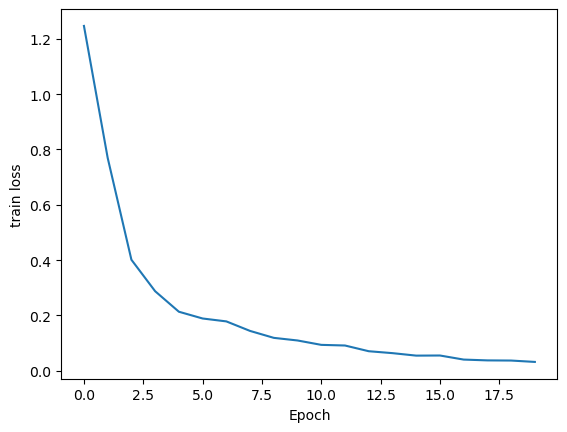

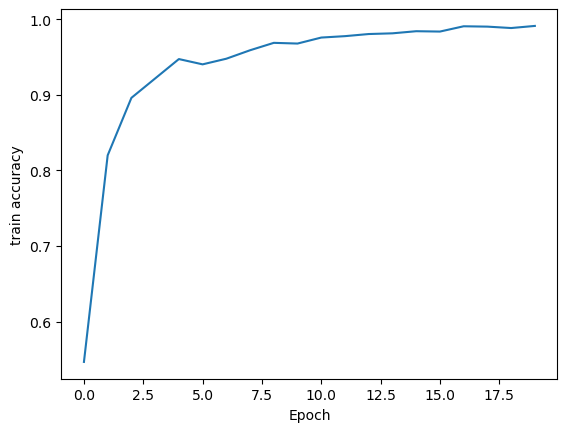

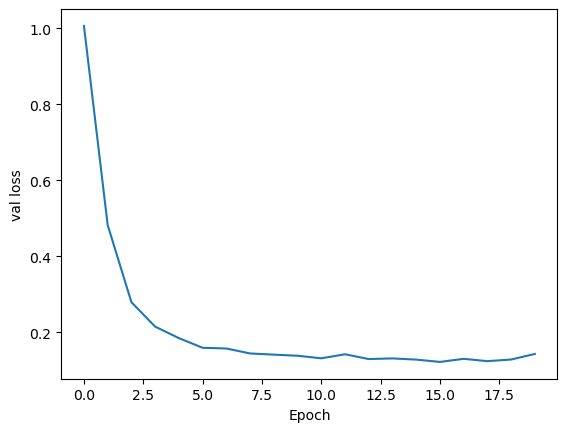

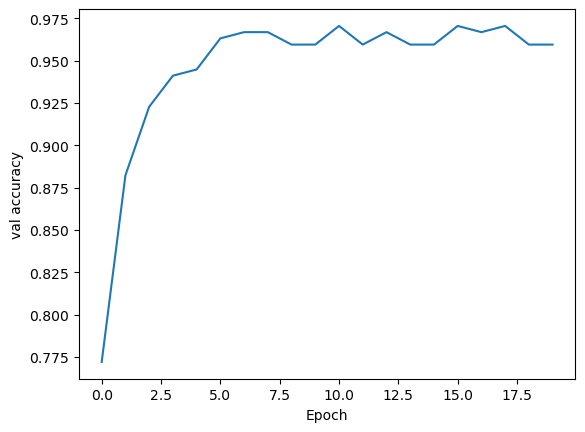

In [74]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

# Testing

In [75]:
preds = []
actual = []

tot_loss = tot_acc = count = 0

for images, labels in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 34/34 [00:03<00:00, 10.75it/s]

Test Loss: 0.15363341569900513, Test Accuracy: 0.966911792755127


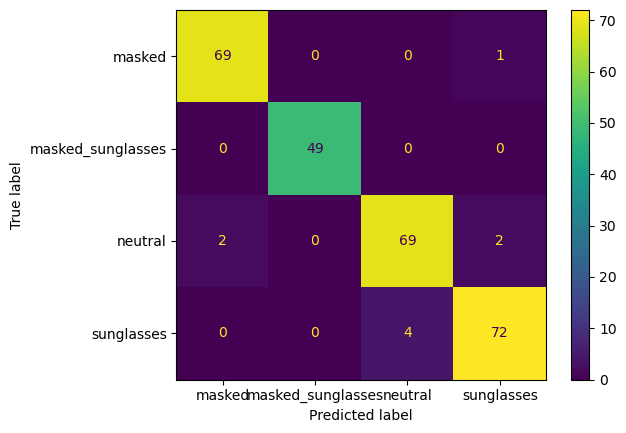

In [76]:
class_labels = sorted(dataset.class_lbl.keys())

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

In [77]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]

In [78]:
stats

,Precision,Recall
masked,0.971831,0.985714
masked_sunglasses,1.000000,1.000000
neutral,0.945205,0.945205
sunglasses,0.960000,0.947368


# Inference

In [88]:
model_infer = torch.load("saved_models/model_14.pth")

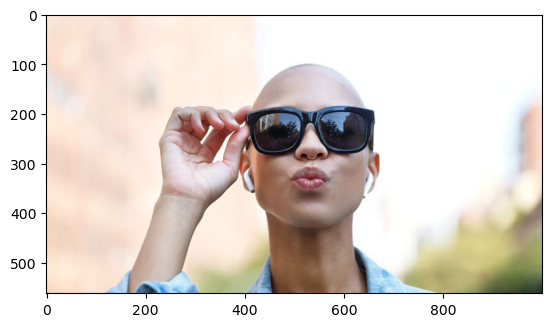

Image class:  sunglasses


In [90]:

img_infer = read_image("../Face_detection/examples/download.jpg", ImageReadMode.RGB).float()
img = plt.imread("../Face_detection/examples/download.jpg")
imgplot = plt.imshow(img)
plt.show()

img_infer = img_infer[None, :, : , :]
# assert img_infer.shape == ()
result = model_infer(img_infer.to(device))
out_label = torch.argmax(result, dim=1)

out = out_label.cpu().detach().numpy()
for key, val in dataset.class_lbl.items():
    if(val == out[0]): 
        print("Image class: ", key)